In [29]:
import pandas as pd
import seaborn as sns
from collections import Counter
import numpy as np
import json
import re
from sklearn.feature_extraction.text import CountVectorizer

In [1]:
ONTOLOGY_PATH = '/Users/Joe/Downloads/SNOMED_CF.csv'
ONTOLOGY_PATH = '/Users/Joe/Downloads/CCFO.csv'

In [75]:
def get_cleaned_name2cid(c2name):
    cleaned_name2cid = {}
    for k, v in c2name.items():
        v = re.sub('[^a-zA-Z0-9]+', ' ', v)
        cleaned_name2cid[v] = k
    return cleaned_name2cid

def get_vocab2concept_dict(count_vectorizer, cleaned_name2cid):
    vid2cid = {}
    for k, v in count_vectorizer.vocabulary_.items():
        if k in cleaned_name2cid:
            vid2cid[v] = cleaned_name2cid[k]
            print("matched word:", k)
    # print("vocab2concept_dict:", vid2cid)
    return vid2cid

def get_CountVectorizer(text, allow_list=None, min_df=1):
    vectorizer = CountVectorizer(
        lowercase=True, token_pattern='[a-zA-Z]{2,}',
        ngram_range=(1,3), min_df=min_df, stop_words='english', vocabulary=allow_list) 
    # low_risk_vectorizer.fit(low_risk_cohort_note['notes_groupby_enc'].values)
    X = vectorizer.fit_transform(text)
    print("Ten words in the vocabulary:")
    print(vectorizer.get_feature_names()[:10])
    print(X.shape)
    return vectorizer, X


def get_selected_concept_id(max_token_len=3):
    CF = pd.read_csv(ONTOLOGY_PATH)
    cf_wordlist = []
    check_set = set()
    allowed_concept_ids = []
    for i, row in CF.iterrows():
        s = str(row['Preferred Label']).lower()
        cid = row["Class ID"].split("#")[-1]
        if cid == "404684003":
            continue
        tokens = re.findall('[a-z]+', s)
        concept = " ".join(tokens)
        if 0 < len(tokens) <= max_token_len:
            if concept not in check_set:
                allowed_concept_ids.append(cid)
                cf_wordlist.append(concept)
                check_set.add(concept)
    return allowed_concept_ids, cf_wordlist

def get_laycount(count_vector, vid2cid, relation_c2layer1, allowed_concept_ids):
    """
    summing of number of concepts appears of the selected layer.
    """
    allowed_concept_ids = set(allowed_concept_ids)
    counter = Counter()
    # c2layer1 = list(relation_c2layer1.values())
    # mapped_c2layer1 = [cc for i,cc in enumerate(c2layer1) if i in allowed_concept_ids]
    mapped_c2layer1 = {}
    for cid, layer1ids in relation_c2layer1.items():
        if cid in allowed_concept_ids:
            mapped_c2layer1[cid] = layer1ids
    for c in count_vector:
        counts = np.where(np.array(c.toarray()).flatten()>0)[0]
        for count in counts:
            matched_cid = vid2cid.get(count, None)
            if matched_cid and matched_cid in mapped_c2layer1:
                counter.update(mapped_c2layer1[matched_cid])
    return counter

def sort_two_lists(list1, list2):
    zipped_lists = zip(list1, list2)
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    list1, list2 = [ list(tuple) for tuple in  tuples]
    return list1, list2

In [72]:
relation_c2layer1 = json.load(open("/Users/Joe/Downloads/relation_c2layer1.json"))
c2name = json.load(open("/Users/Joe/Downloads/snomed_c2name.json"))
cleaned_name2cid = get_cleaned_name2cid(c2name)

In [73]:
allowed_concept_ids, cf_wordlist = get_selected_concept_id()

/var/folders/t4/bhf59vs90_141wj5x6wyvcpw0000gn/T/ipykernel_59185/2132314903.py:1: DtypeWarning: Columns (24,28,30) have mixed types.Specify dtype option on import or set low_memory=False.
  allowed_concept_ids, cf_wordlist = get_selected_concept_id()


In [76]:
# load example article from https://journals.physiology.org/doi/full/10.1152/physiol.00024.2019
text = open("example_article1.txt").read()
count_vectorizer, count_vector = get_CountVectorizer([text])
vid2cid = get_vocab2concept_dict(count_vectorizer, cleaned_name2cid)

Ten words in the vocabulary:
['abdominal', 'abdominal adiposity', 'abdominal adiposity researchers', 'abdominal chest', 'abdominal chest wall', 'abdominal wall', 'abdominal wall blocks', 'abdominal wall consequently', 'abdominus', 'abdominus periosteum']
(1, 6514)
matched word: related
matched word: female
matched word: lifestyle
matched word: orientated
matched word: tension
matched word: aging
matched word: stiffness
matched word: newborn
matched word: puberty
matched word: pain
matched word: discomfort
matched word: breast composition
matched word: weight increased
matched word: small breast
matched word: musculoskeletal pain


/Users/joe/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/Users/joe/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

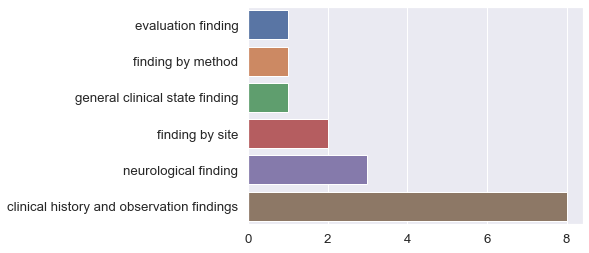

In [68]:
c = get_laycount(count_vector, vid2cid, relation_c2layer1, allowed_concept_ids) # the input is a list of strings
keys = [c2name[k] for k in dict(c).keys()]
k, v = sort_two_lists(list(dict(c).values()), keys)

sns.set(font_scale=1.2)  
sns.barplot(k,v)

In [77]:
# load example article from https://journals.physiology.org/doi/full/10.1152/physiol.00024.2019
text = open("example_article2.txt").read()
count_vectorizer, count_vector = get_CountVectorizer([text])
vid2cid = get_vocab2concept_dict(count_vectorizer, cleaned_name2cid)

Ten words in the vocabulary:
['ability', 'ability monitor', 'ability monitor infectious', 'able', 'able cover', 'able cover policy', 'absence', 'absence violence', 'absence violence terrorism', 'absence violence terrorismd']
(1, 4889)
matched word: related
matched word: crisis
matched word: aids
matched word: disease
matched word: birth
matched word: male
matched word: female
matched word: obesity
matched word: pressure
matched word: measles
matched word: problem
matched word: willing
matched word: infectious disease
matched word: cerebrovascular disease
matched word: accidental injury
matched word: diabetes mellitus


/Users/joe/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

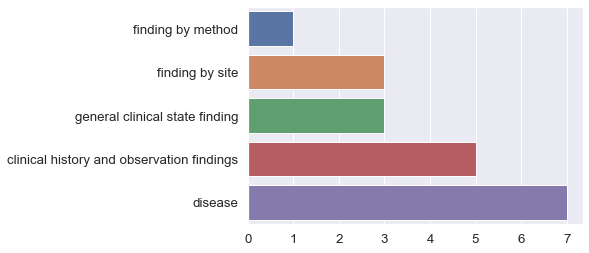

In [70]:
c = get_laycount(count_vector, vid2cid, relation_c2layer1, allowed_concept_ids) # the input is a list of strings
keys = [c2name[k] for k in dict(c).keys()]
k, v = sort_two_lists(list(dict(c).values()), keys)

sns.set(font_scale=1.2)  
sns.barplot(k,v)